In [1]:
from keras_preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input,Conv2D,LeakyReLU,Flatten,Dropout,Dense,Reshape,Conv2DTranspose,BatchNormalization
import tensorflow as tf

In [2]:
root_dir = "C:/Users/Mask/Desktop/AIML Projects/Semi -Supervised GANS for Melanoma Detection/MelanomaDetection"

In [3]:
unlabeled_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True,rescale=1.0/255.0)

In [4]:
unlabeled_datagen = unlabeled_data_gen.flow_from_directory(directory=root_dir,
                                                           target_size=(32,32),classes=['unlabeled'],batch_size=256)

Found 7018 images belonging to 1 classes.


In [5]:
def discriminator():

  dis = Sequential(name="Discriminator")

  dis.add(Conv2D(filters=64,kernel_size=4,strides=2,padding="same",input_shape=(32,32,3),use_bias=False))
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Conv2D(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Conv2D(filters=256,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Flatten())
  dis.add(Dropout(0.4))

  dis.add(Dense(units=1,activation="sigmoid"))

  return dis

In [6]:
def generator():

  noise_shape = 100
  gen = Sequential(name="Generator")

  gen.add(Input(shape=(noise_shape,)))
  gen.add(Dense(units=4*4*100))
  gen.add(Reshape((4,4,100)))

  gen.add(Conv2DTranspose(filters=256,kernel_size=4,strides=1,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=64,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=3,kernel_size=4,strides=2,padding="same",activation="tanh",use_bias=False))

  return gen

In [7]:
D = discriminator()

In [8]:
D.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        3072      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131072    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 128)        512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         524288    
                                                     

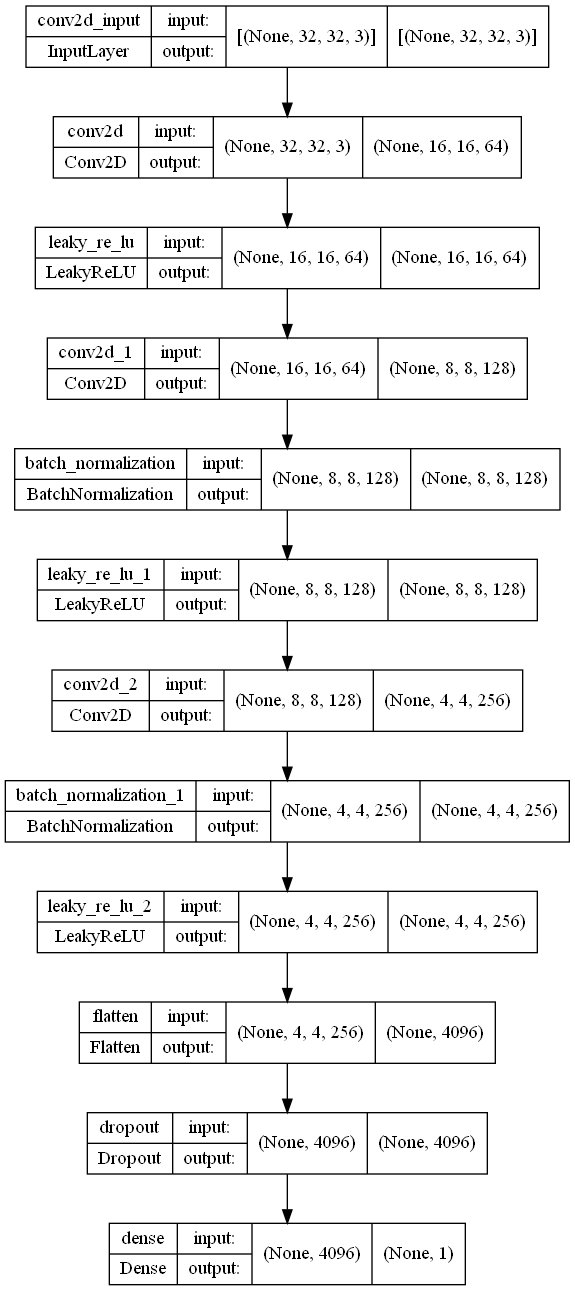

In [9]:
tf.keras.utils.plot_model(model=D,show_shapes=True)

In [10]:
G = generator()

In [11]:
G.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1600)              161600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        409600    
 nspose)                                                         
                                                                 
 batch_normalization_2 (Batc  (None, 4, 4, 256)        1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 128)        52

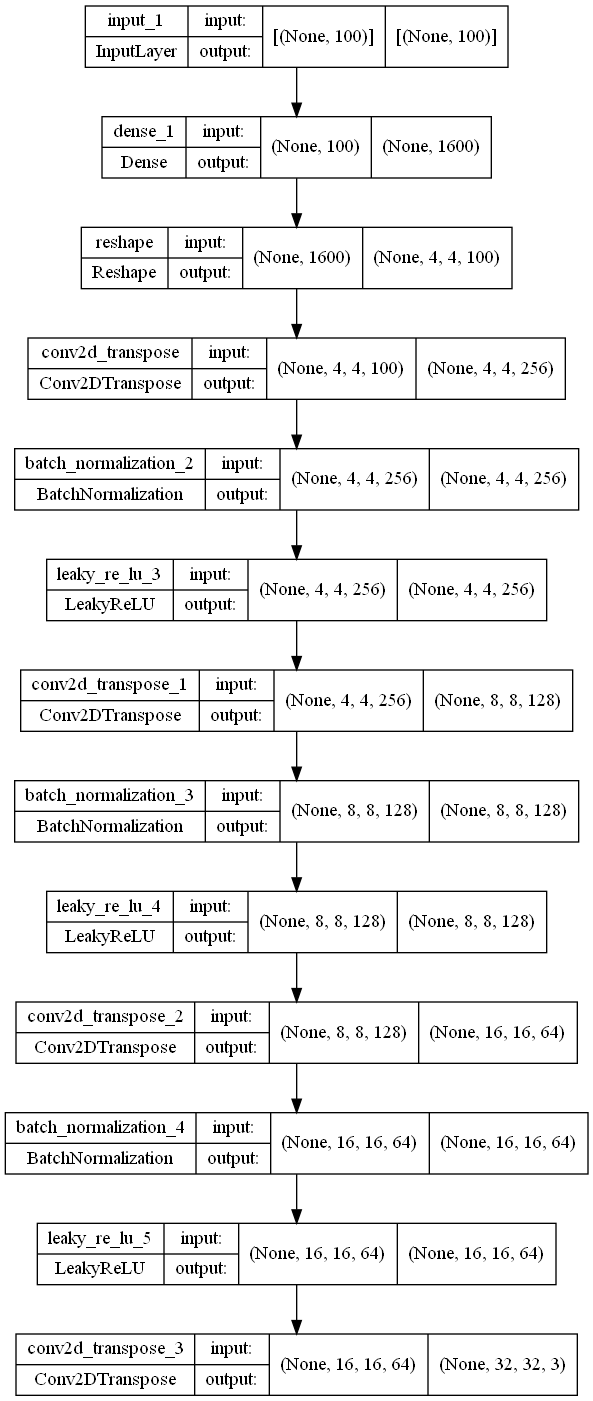

In [12]:
tf.keras.utils.plot_model(model=G,show_shapes=True)

In [13]:
random_noise = tf.random.normal(shape=(1,100))

In [14]:
random_noise = tf.random.normal(shape=(1,100))
generated_image = G(random_noise,training=False)

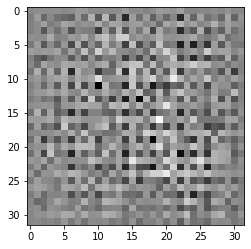

In [15]:
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [16]:
posterior = D(generated_image)

In [17]:
print(posterior)

tf.Tensor([[0.49943507]], shape=(1, 1), dtype=float32)


In [18]:
GAN_epochs = 50
noise_shape = 100
batch_size = 256

In [19]:
import keras
from IPython import display
import numpy as np

In [20]:
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [21]:
def D_loss(real_imgs_preds,fake_imgs_preds):

  real_imgs_labels = 0.05 * tf.random.uniform(shape=tf.shape(real_imgs_preds)) + tf.ones_like(real_imgs_preds)
  fake_imgs_labels = 0.05 * tf.random.uniform(shape=tf.shape(fake_imgs_preds)) + tf.zeros_like(fake_imgs_preds)

  real_imgs_bce_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
  fake_imgs_bce_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

  total_loss = real_imgs_bce_loss + fake_imgs_bce_loss

  return total_loss

In [22]:
def G_loss(fake_imgs_preds):

  fake_imgs_labels = tf.ones_like(fake_imgs_preds)

  return bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

In [23]:
D_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0008,beta_1=0.3)
G_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0004,beta_1=0.1)

In [24]:
GAN_checkpoint_dir = os.path.join(root_dir ,"Checkpoint")
GAN_checkpoint_prefix = os.path.join(GAN_checkpoint_dir,"ckpt")
GAN_checkpoint = tf.train.Checkpoint(optimizer=[D_optimizer,G_optimizer],model=[D,G])

In [25]:
@tf.function
def training_step(real_imgs_mini_batch):

  G.trainable = False
  noise = tf.random.normal(shape=(batch_size,noise_shape))
  generated_imgs_mini_batch = G(noise,training=False)

  D.trainable = True

  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:

    real_imgs_preds = D(real_imgs_mini_batch,training=True)
    fake_imgs_preds = D(generated_imgs_mini_batch,training=True)

    disc_loss = D_loss(real_imgs_preds,fake_imgs_preds)

    gradients_of_disc = disc_tape.gradient(disc_loss,D.trainable_variables)
    D_optimizer.apply_gradients(zip(gradients_of_disc,D.trainable_variables))

    D.trainable = False
    G.trainable = True

    #noise = tf.random.normal(shape=(batch_size,noise_shape))
    #generated_imgs_mini_batch = G(noise,training=True)

    #fake_imgs_preds = D(generated_imgs_mini_batch,training=False)

    gen_loss = G_loss(fake_imgs_preds)

    gradients_of_gen = gen_tape.gradient(gen_loss,G.trainable_variables)
    G_optimizer.apply_gradients(zip(gradients_of_gen,G.trainable_variables))

    print("Ran Training Step")

    return disc_loss,gen_loss

In [26]:
constant_noise = tf.random.normal(shape=(16,noise_shape))

In [27]:
real_imgs_path = os.path.join(root_dir ,"unlabeled")

In [28]:
def generate_and_save_images(generator_model,epoch,test_input):

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(generated_sample_images.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.savefig("C:/Users/Mask/Desktop/AIML Projects/Semi -Supervised GANS for Melanoma Detection/MelanomaDetection/Generator fig/Images_at_Epoch_{:04d}.png".format(epoch))
  plt.show()

In [29]:
def train_gan(real_imgs_datagen,total_epochs):

  for epoch in range(total_epochs):

    time_step = 1

    for image_batch in real_imgs_datagen:

      print("Time Step: {}, Epoch: {}".format(time_step,epoch+1))

      with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:

        G.trainable = False
        noise = tf.random.normal(shape=(batch_size,noise_shape))
        generated_imgs_mini_batch = G(noise,training=False)

        D.trainable = True

        real_imgs_preds = D(image_batch[0],training=True)
        fake_imgs_preds = D(generated_imgs_mini_batch,training=True)

        disc_loss = D_loss(real_imgs_preds,fake_imgs_preds)

        gradients_of_disc = disc_tape.gradient(disc_loss,D.trainable_variables)
        D_optimizer.apply_gradients(zip(gradients_of_disc,D.trainable_variables))

        D.trainable = False
        G.trainable = True

        #noise = tf.random.normal(shape=(batch_size,noise_shape))
        #generated_imgs_mini_batch = G(noise,training=True)

        #fake_imgs_preds = D(generated_imgs_mini_batch,training=False)

        gen_loss = G_loss(fake_imgs_preds)

        gradients_of_gen = gen_tape.gradient(gen_loss,G.trainable_variables)
        G_optimizer.apply_gradients(zip(gradients_of_gen,G.trainable_variables))

        print("Discriminator Loss: {}, Generator Loss: {}\n".format(disc_loss,gen_loss))

      if time_step > len(os.listdir(real_imgs_path))//batch_size:
        break

      time_step = time_step + 1

    generate_and_save_images(generator_model=G,epoch=epoch+1,test_input=constant_noise)

    if (epoch + 1) % 5 == 0:
      GAN_checkpoint.save(file_prefix=GAN_checkpoint_prefix)

  generate_and_save_images(generator_model=G,epoch=total_epochs,test_input=constant_noise)

In [31]:
# train_gan(real_imgs_datagen=unlabeled_datagen,total_epochs=GAN_epochs)

In [107]:
latest_checkpoint_path = tf.train.latest_checkpoint(os.path.join(root_dir , "Checkpoint"))

In [108]:
latest_checkpoint_path

'C:/Users/Mask/Desktop/AIML Projects/Semi -Supervised GANS for Melanoma Detection/MelanomaDetection\\Checkpoint\\ckpt-10'

In [109]:
GAN_checkpoint.restore(latest_checkpoint_path)

In [110]:
def generate_and_save_images(generator_model,test_input):

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

#   plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


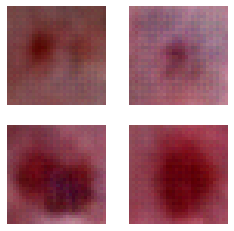

In [111]:
generate_and_save_images(generator_model=G,test_input=constant_noise)

In [112]:
unlbld_imgs_base_path = os.path.join(root_dir ,"unlabeled")

In [113]:
from random import randint

In [114]:
imgs_names_list = os.listdir(unlbld_imgs_base_path)

In [115]:
total_imgs = len(imgs_names_list)

In [116]:
single_img = plt.imread(os.path.join(unlbld_imgs_base_path,imgs_names_list[randint(0,total_imgs-1)]))

Text(0.5, 1.0, 'Real Unlabeled Image')

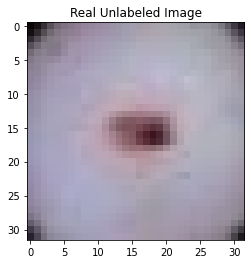

In [117]:
plt.imshow(single_img)
plt.title("Real Unlabeled Image")

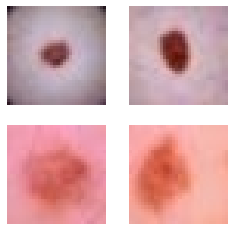

In [118]:
plt.figure(figsize=(4,4))
image = plt.imread(os.path.join(unlbld_imgs_base_path,imgs_names_list[randint(0,total_imgs-1)]))

for i in range(4):
#     plt.title("Real Image")
    plt.subplot(2,2,i+1)
    plt.imshow(plt.imread(os.path.join(unlbld_imgs_base_path,imgs_names_list[randint(0,total_imgs-1)])))
    plt.axis("off")

In [119]:
single_fake_img = G(tf.random.normal(shape=(1,100)))
single_fake_img.shape

TensorShape([1, 32, 32, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Fake Imag Generated by Generator')

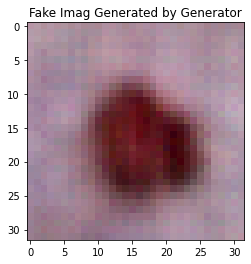

In [120]:
plt.imshow(single_fake_img[0,:,:,:])
plt.title("Fake Imag Generated by Generator")

In [121]:
def discriminator_base():

  input_to_cls = Input(shape=(32,32,3))

  disc_base = Sequential(name="disc_base")
  disc_base.add(input_to_cls)

  for layer in D.layers[0:10]:
    disc_base.add(layer)

  return disc_base

In [122]:
def unsupervised_classifier():

  disc_base = discriminator_base()

  disc_base.add(Dense(units=1,activation="sigmoid"))

  return disc_base

In [123]:
def supervised_classifier():

  disc_base = discriminator_base()

  disc_base.add(Dense(units=1,activation="sigmoid"))

  return disc_base

In [124]:
unsupervised_cls = unsupervised_classifier()
supervised_cls = supervised_classifier()

In [172]:
unsupervised_cls_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0001,beta_1=0.1)
supervised_cls_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.000001,beta_1=0.1)

In [126]:
supervised_cls_train_acc_metric = tf.keras.metrics.BinaryAccuracy()
supervised_cls_cv_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [127]:
def unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds):
    real_imgs_labels = tf.ones_like(real_imgs_preds)
    fake_imgs_labels = tf.zeros_like(fake_imgs_preds)

    real_imgs_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
    fake_imgs_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

    total_loss = real_imgs_loss + fake_imgs_loss

    return total_loss

In [128]:
def supervised_cls_loss(imgs_labels,imgs_preds):
    
    imgs_label = np.array(imgs_labels)
    
    imgs_labels = imgs_labels.reshape(imgs_labels.shape[0],1)
#     imgs_preds = imgs_preds.reshape(imgs_preds.shape[0],1)
    return bce_loss(y_true=imgs_labels,y_pred=imgs_preds)

In [129]:
@tf.function
def ssl_training_step(labeled_images,unlabeled_images):

  G.trainable = False
  unsupervised_cls.trainable = True
  supervised_cls.trainable = True

  with tf.GradientTape() as supervised_cls_tape, tf.GradientTape() as unsupervised_cls_tape, tf.GradientTape() as gen_tape:

    labeled_imgs_preds = supervised_cls(labeled_images[0],training=True)
    
    supervised_loss = supervised_cls_loss(imgs_labels=labeled_images[1],imgs_preds=labeled_imgs_preds)

    gradients_of_supervised_cls = supervised_cls_tape.gradient(supervised_loss,supervised_cls.trainable_variables)
    supervised_cls_optimizer.apply_gradients(zip(gradients_of_supervised_cls,supervised_cls.trainable_variables))

    noise = tf.random.normal(shape=(batch_size,noise_shape))
    generated_images = G(noise,training=False)

    real_imgs_preds = unsupervised_cls(unlabeled_images,training=True)
    fake_imgs_preds = unsupervised_cls(generated_images,training=True)

    unsupervised_loss = unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds)

    gradients_of_unsupervised_cls = unsupervised_cls_tape.gradient(unsupervised_loss,unsupervised_cls.trainable_variables)
    unsupervised_cls_optimizer.apply_gradients(zip(gradients_of_unsupervised_cls,unsupervised_cls.trainable_variables))

    supervised_cls.trainable = False
    unsupervised_cls.trainable = False

  return supervised_loss,labeled_imgs_preds

In [130]:
cls_checkpoint_dir = os.path.join(root_dir , "Finetune_GAN")
checkpoint_prefix = os.path.join(cls_checkpoint_dir,"ckpt")
cls_checkpoint = tf.train.Checkpoint(optimizer=[supervised_cls_optimizer,unsupervised_cls_optimizer],
                                     model=[supervised_cls,unsupervised_cls])

In [56]:
# mkdir_Beneign = os.mkdir(os.path.join(root_dir,"test/Beneign"))
# mkdir_malignant = os.mkdir(os.path.join(root_dir,"test/Malignant"))

In [131]:
import shutil as s

In [58]:

# def segregating_labeled_in_Benign_and_Malignant(path):
#     for img in os.listdir(path):
#         if img[-5] =="0":
#             s.move(os.path.join(path,img),os.path.join(path,"Beneign"))
#         else:
#             s.move(os.path.join(path,img),os.path.join(path,"Malignant"))

# segregating_labeled_in_Benign_and_Malignant(os.path.join(root_dir,"test"))

In [132]:
cls_epochs = 50

In [133]:
cv_data_gen = ImageDataGenerator()

In [134]:
cv_datagen = cv_data_gen.flow_from_directory(directory=os.path.join(root_dir , "test"),
                                             target_size=(32,32),
                                             classes=os.listdir(os.path.join(root_dir , "test")),
                                             class_mode="binary",batch_size=300,
                                            shuffle=False)

Found 600 images belonging to 2 classes.


In [135]:
labeled_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True,rescale=1.0/255.0)

In [136]:
labeled_datagen = labeled_data_gen.flow_from_directory(directory=os.path.join(root_dir , "labeled"),
                                                       target_size=(32,32),
                                                       classes=os.listdir(os.path.join(root_dir , "labeled")),
                                                       class_mode="binary",batch_size=7)

Found 200 images belonging to 2 classes.


In [144]:
train_acc = []
train_loss =  []
cv_acc = []
supervised_cls_loss_data = []
unsupervised_cls_loss_data = []

In [145]:
def train_ssl_classifier(labeled_imgs_datagen,unlabeled_imgs_datagen,cv_imgs_datagen,total_epochs):
  
  for epoch in range(total_epochs):

    time_step = 1

    for labeled_images_batch, unlabeled_images_batch in zip(labeled_imgs_datagen,unlabeled_imgs_datagen):

      with tf.GradientTape() as supervised_cls_tape, tf.GradientTape() as unsupervised_cls_tape, tf.GradientTape() as gen_tape:

        G.trainable = False
        unsupervised_cls.trainable = True
        supervised_cls.trainable = True

        labeled_imgs_preds = supervised_cls(labeled_images_batch[0],training=True)
    
        supervised_loss = supervised_cls_loss(imgs_labels=labeled_images_batch[1],imgs_preds=labeled_imgs_preds)

        gradients_of_supervised_cls = supervised_cls_tape.gradient(supervised_loss,supervised_cls.trainable_variables)
        supervised_cls_optimizer.apply_gradients(zip(gradients_of_supervised_cls,supervised_cls.trainable_variables))

        noise = tf.random.normal(shape=(batch_size,noise_shape))
        generated_images = G(noise,training=False)

        real_imgs_preds = unsupervised_cls(unlabeled_images_batch[0],training=True)
        fake_imgs_preds = unsupervised_cls(generated_images,training=True)

        unsupervised_loss = unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds)

        gradients_of_unsupervised_cls = unsupervised_cls_tape.gradient(unsupervised_loss,unsupervised_cls.trainable_variables)
        unsupervised_cls_optimizer.apply_gradients(zip(gradients_of_unsupervised_cls,unsupervised_cls.trainable_variables))

        supervised_cls.trainable = False
        unsupervised_cls.trainable = False
        
        supervised_cls_loss_data.append(supervised_loss)
        unsupervised_cls_loss_data.append(unsupervised_loss)
        
        
      if time_step > len(os.listdir(os.path.join(root_dir , "unlabeled")))//batch_size:
        break

      supervised_cls_train_acc_metric.update_state(labeled_images_batch[1],labeled_imgs_preds)
      print("Training Loss at Time Step {} of Epoch {} is {}".format(time_step, epoch+1, float(supervised_loss)))

      time_step = time_step + 1

    training_accuracy = supervised_cls_train_acc_metric.result()
    print("\nTraining Accuracy after Epoch {} is {}".format(epoch+1,float(training_accuracy)))
    train_acc.append(training_accuracy)
    train_loss.append(supervised_loss)

    supervised_cls_train_acc_metric.reset_states()

    cv_time_steps = 0

    for X_cv,Y_cv_labels in cv_imgs_datagen:

      if cv_time_steps > 300//300:
        break

      cv_time_steps = cv_time_steps + 1

      Y_cv_preds = supervised_cls(X_cv,training=False)
      supervised_cls_cv_acc_metric.update_state(Y_cv_labels,Y_cv_preds)

    cv_accuracy = supervised_cls_cv_acc_metric.result()
    print("Cross Validation Accuracy after Epoch {} is {}\n".format(epoch+1,float(cv_accuracy)))
    cv_acc.append(cv_accuracy)

    supervised_cls_cv_acc_metric.reset_states()

    cls_checkpoint.save(file_prefix=checkpoint_prefix)
    
  return supervised_cls_loss, unsupervised_cls_loss, train_loss, train_acc, cv_acc

In [173]:
train_ssl_classifier(labeled_imgs_datagen=labeled_datagen,unlabeled_imgs_datagen=unlabeled_datagen,
                     cv_imgs_datagen=cv_datagen,total_epochs=50)

Training Loss at Time Step 1 of Epoch 1 is 0.6664904356002808
Training Loss at Time Step 2 of Epoch 1 is 0.4378097951412201
Training Loss at Time Step 3 of Epoch 1 is 0.5212275981903076
Training Loss at Time Step 4 of Epoch 1 is 0.08707885444164276
Training Loss at Time Step 5 of Epoch 1 is 0.08633656054735184
Training Loss at Time Step 6 of Epoch 1 is 0.31373733282089233
Training Loss at Time Step 7 of Epoch 1 is 0.27491337060928345
Training Loss at Time Step 8 of Epoch 1 is 0.4104948043823242
Training Loss at Time Step 9 of Epoch 1 is 0.4111657738685608
Training Loss at Time Step 10 of Epoch 1 is 0.3521304130554199
Training Loss at Time Step 11 of Epoch 1 is 0.45625025033950806
Training Loss at Time Step 12 of Epoch 1 is 0.13545091450214386
Training Loss at Time Step 13 of Epoch 1 is 0.4669798016548157
Training Loss at Time Step 14 of Epoch 1 is 0.2083519846200943
Training Loss at Time Step 15 of Epoch 1 is 0.8911235928535461
Training Loss at Time Step 16 of Epoch 1 is 0.230967447161

Training Loss at Time Step 16 of Epoch 5 is 0.6501926779747009
Training Loss at Time Step 17 of Epoch 5 is 0.8214918375015259
Training Loss at Time Step 18 of Epoch 5 is 0.09378153085708618
Training Loss at Time Step 19 of Epoch 5 is 0.6316318511962891
Training Loss at Time Step 20 of Epoch 5 is 0.25347650051116943
Training Loss at Time Step 21 of Epoch 5 is 0.17700256407260895
Training Loss at Time Step 22 of Epoch 5 is 0.20353619754314423
Training Loss at Time Step 23 of Epoch 5 is 0.07406507432460785
Training Loss at Time Step 24 of Epoch 5 is 0.23606683313846588
Training Loss at Time Step 25 of Epoch 5 is 0.11102359741926193
Training Loss at Time Step 26 of Epoch 5 is 0.213732048869133
Training Loss at Time Step 27 of Epoch 5 is 0.8524540662765503

Training Accuracy after Epoch 5 is 0.8227513432502747
Cross Validation Accuracy after Epoch 5 is 0.6683333516120911

Training Loss at Time Step 1 of Epoch 6 is 0.36366337537765503
Training Loss at Time Step 2 of Epoch 6 is 0.743622958660

Training Loss at Time Step 2 of Epoch 10 is 0.1009993702173233
Training Loss at Time Step 3 of Epoch 10 is 0.7270622253417969
Training Loss at Time Step 4 of Epoch 10 is 0.401357501745224
Training Loss at Time Step 5 of Epoch 10 is 0.3469914495944977
Training Loss at Time Step 6 of Epoch 10 is 0.10465572774410248
Training Loss at Time Step 7 of Epoch 10 is 0.325865238904953
Training Loss at Time Step 8 of Epoch 10 is 0.09151310473680496
Training Loss at Time Step 9 of Epoch 10 is 0.1284637749195099
Training Loss at Time Step 10 of Epoch 10 is 0.09005222469568253
Training Loss at Time Step 11 of Epoch 10 is 0.3656488358974457
Training Loss at Time Step 12 of Epoch 10 is 0.31618645787239075
Training Loss at Time Step 13 of Epoch 10 is 0.27475377917289734
Training Loss at Time Step 14 of Epoch 10 is 0.3474903702735901
Training Loss at Time Step 15 of Epoch 10 is 0.07934433966875076
Training Loss at Time Step 16 of Epoch 10 is 0.11192649602890015
Training Loss at Time Step 17 of Epoch 10 i

Training Loss at Time Step 15 of Epoch 14 is 0.26178261637687683
Training Loss at Time Step 16 of Epoch 14 is 0.1684790700674057
Training Loss at Time Step 17 of Epoch 14 is 0.24717435240745544
Training Loss at Time Step 18 of Epoch 14 is 0.40668168663978577
Training Loss at Time Step 19 of Epoch 14 is 0.2921275496482849
Training Loss at Time Step 20 of Epoch 14 is 0.16076621413230896
Training Loss at Time Step 21 of Epoch 14 is 0.2707885205745697
Training Loss at Time Step 22 of Epoch 14 is 0.5538212656974792
Training Loss at Time Step 23 of Epoch 14 is 0.16924013197422028
Training Loss at Time Step 24 of Epoch 14 is 0.16426227986812592
Training Loss at Time Step 25 of Epoch 14 is 0.3154298961162567
Training Loss at Time Step 26 of Epoch 14 is 0.11452800780534744
Training Loss at Time Step 27 of Epoch 14 is 0.1769489347934723

Training Accuracy after Epoch 14 is 0.8518518805503845
Cross Validation Accuracy after Epoch 14 is 0.653333306312561

Training Loss at Time Step 1 of Epoch 15 i


Training Accuracy after Epoch 18 is 0.8677248358726501
Cross Validation Accuracy after Epoch 18 is 0.6599999666213989

Training Loss at Time Step 1 of Epoch 19 is 0.3589160740375519
Training Loss at Time Step 2 of Epoch 19 is 0.3675200045108795
Training Loss at Time Step 3 of Epoch 19 is 0.2800540030002594
Training Loss at Time Step 4 of Epoch 19 is 0.2536303699016571
Training Loss at Time Step 5 of Epoch 19 is 0.1801295280456543
Training Loss at Time Step 6 of Epoch 19 is 0.2124602049589157
Training Loss at Time Step 7 of Epoch 19 is 0.4897087514400482
Training Loss at Time Step 8 of Epoch 19 is 0.6265899538993835
Training Loss at Time Step 9 of Epoch 19 is 0.2685559093952179
Training Loss at Time Step 10 of Epoch 19 is 0.4308079183101654
Training Loss at Time Step 11 of Epoch 19 is 0.26239296793937683
Training Loss at Time Step 12 of Epoch 19 is 0.5064510703086853
Training Loss at Time Step 13 of Epoch 19 is 0.19455769658088684
Training Loss at Time Step 14 of Epoch 19 is 0.48590770

Training Loss at Time Step 13 of Epoch 23 is 0.7611432075500488
Training Loss at Time Step 14 of Epoch 23 is 0.6917290091514587
Training Loss at Time Step 15 of Epoch 23 is 1.2566486597061157
Training Loss at Time Step 16 of Epoch 23 is 1.5445412397384644
Training Loss at Time Step 17 of Epoch 23 is 0.26078155636787415
Training Loss at Time Step 18 of Epoch 23 is 0.8754881024360657
Training Loss at Time Step 19 of Epoch 23 is 0.5597981810569763
Training Loss at Time Step 20 of Epoch 23 is 0.4203405976295471
Training Loss at Time Step 21 of Epoch 23 is 1.1094913482666016
Training Loss at Time Step 22 of Epoch 23 is 0.2933818995952606
Training Loss at Time Step 23 of Epoch 23 is 0.41520875692367554
Training Loss at Time Step 24 of Epoch 23 is 0.48298341035842896
Training Loss at Time Step 25 of Epoch 23 is 1.0746729373931885
Training Loss at Time Step 26 of Epoch 23 is 0.6499357223510742
Training Loss at Time Step 27 of Epoch 23 is 0.6761091947555542

Training Accuracy after Epoch 23 is 

Training Loss at Time Step 27 of Epoch 27 is 0.949710488319397

Training Accuracy after Epoch 27 is 0.7103173732757568
Cross Validation Accuracy after Epoch 27 is 0.5

Training Loss at Time Step 1 of Epoch 28 is 0.16219016909599304
Training Loss at Time Step 2 of Epoch 28 is 0.3051901161670685
Training Loss at Time Step 3 of Epoch 28 is 0.6560107469558716
Training Loss at Time Step 4 of Epoch 28 is 0.5766350626945496
Training Loss at Time Step 5 of Epoch 28 is 0.8449977040290833
Training Loss at Time Step 6 of Epoch 28 is 0.44280025362968445
Training Loss at Time Step 7 of Epoch 28 is 0.34637969732284546
Training Loss at Time Step 8 of Epoch 28 is 0.6919729113578796
Training Loss at Time Step 9 of Epoch 28 is 0.5619713664054871
Training Loss at Time Step 10 of Epoch 28 is 0.7537811994552612
Training Loss at Time Step 11 of Epoch 28 is 0.3052135109901428
Training Loss at Time Step 12 of Epoch 28 is 0.5086673498153687
Training Loss at Time Step 13 of Epoch 28 is 0.20519036054611206
Train

Training Loss at Time Step 13 of Epoch 32 is 0.3762471675872803
Training Loss at Time Step 14 of Epoch 32 is 0.276114284992218
Training Loss at Time Step 15 of Epoch 32 is 0.18076910078525543
Training Loss at Time Step 16 of Epoch 32 is 0.7182140350341797
Training Loss at Time Step 17 of Epoch 32 is 0.17007459700107574
Training Loss at Time Step 18 of Epoch 32 is 0.579253077507019
Training Loss at Time Step 19 of Epoch 32 is 0.37351760268211365
Training Loss at Time Step 20 of Epoch 32 is 0.9843534231185913
Training Loss at Time Step 21 of Epoch 32 is 0.19181905686855316
Training Loss at Time Step 22 of Epoch 32 is 0.25288257002830505
Training Loss at Time Step 23 of Epoch 32 is 0.30038705468177795
Training Loss at Time Step 24 of Epoch 32 is 0.6255115866661072
Training Loss at Time Step 25 of Epoch 32 is 0.30783531069755554
Training Loss at Time Step 26 of Epoch 32 is 0.22377805411815643
Training Loss at Time Step 27 of Epoch 32 is 0.2678348124027252

Training Accuracy after Epoch 32 

Training Loss at Time Step 27 of Epoch 36 is 0.23310604691505432

Training Accuracy after Epoch 36 is 0.8571428656578064
Cross Validation Accuracy after Epoch 36 is 0.5

Training Loss at Time Step 1 of Epoch 37 is 0.4014013409614563
Training Loss at Time Step 2 of Epoch 37 is 0.5048494935035706
Training Loss at Time Step 3 of Epoch 37 is 0.18046525120735168
Training Loss at Time Step 4 of Epoch 37 is 0.21466337144374847
Training Loss at Time Step 5 of Epoch 37 is 0.33495277166366577
Training Loss at Time Step 6 of Epoch 37 is 0.37362954020500183
Training Loss at Time Step 7 of Epoch 37 is 1.1421171426773071
Training Loss at Time Step 8 of Epoch 37 is 0.840691864490509
Training Loss at Time Step 9 of Epoch 37 is 0.4710649847984314
Training Loss at Time Step 10 of Epoch 37 is 0.42357295751571655
Training Loss at Time Step 11 of Epoch 37 is 0.22309036552906036
Training Loss at Time Step 12 of Epoch 37 is 0.6441563367843628
Training Loss at Time Step 13 of Epoch 37 is 0.33182018995285034
T

Training Loss at Time Step 12 of Epoch 41 is 0.336354523897171
Training Loss at Time Step 13 of Epoch 41 is 0.36104005575180054
Training Loss at Time Step 14 of Epoch 41 is 0.07450339943170547
Training Loss at Time Step 15 of Epoch 41 is 0.5439284443855286
Training Loss at Time Step 16 of Epoch 41 is 0.41065528988838196
Training Loss at Time Step 17 of Epoch 41 is 0.49576881527900696
Training Loss at Time Step 18 of Epoch 41 is 0.3243263065814972
Training Loss at Time Step 19 of Epoch 41 is 0.5031582117080688
Training Loss at Time Step 20 of Epoch 41 is 0.48461833596229553
Training Loss at Time Step 21 of Epoch 41 is 0.525185763835907
Training Loss at Time Step 22 of Epoch 41 is 0.558903157711029
Training Loss at Time Step 23 of Epoch 41 is 0.37422245740890503
Training Loss at Time Step 24 of Epoch 41 is 0.36014324426651
Training Loss at Time Step 25 of Epoch 41 is 0.3617001175880432
Training Loss at Time Step 26 of Epoch 41 is 0.3481053113937378
Training Loss at Time Step 27 of Epoch 

Training Loss at Time Step 25 of Epoch 45 is 0.7804645895957947
Training Loss at Time Step 26 of Epoch 45 is 0.6210050582885742
Training Loss at Time Step 27 of Epoch 45 is 0.46971625089645386

Training Accuracy after Epoch 45 is 0.8055554628372192
Cross Validation Accuracy after Epoch 45 is 0.5016666650772095

Training Loss at Time Step 1 of Epoch 46 is 0.6222610473632812
Training Loss at Time Step 2 of Epoch 46 is 0.1851310133934021
Training Loss at Time Step 3 of Epoch 46 is 0.6766247153282166
Training Loss at Time Step 4 of Epoch 46 is 0.2329292595386505
Training Loss at Time Step 5 of Epoch 46 is 0.604070246219635
Training Loss at Time Step 6 of Epoch 46 is 0.3768048584461212
Training Loss at Time Step 7 of Epoch 46 is 0.15852369368076324
Training Loss at Time Step 8 of Epoch 46 is 0.1614610105752945
Training Loss at Time Step 9 of Epoch 46 is 0.6650828123092651
Training Loss at Time Step 10 of Epoch 46 is 0.40820613503456116
Training Loss at Time Step 11 of Epoch 46 is 0.64197677

Training Loss at Time Step 9 of Epoch 50 is 0.3268468976020813
Training Loss at Time Step 10 of Epoch 50 is 0.30911916494369507
Training Loss at Time Step 11 of Epoch 50 is 0.6360390782356262
Training Loss at Time Step 12 of Epoch 50 is 0.5577502846717834
Training Loss at Time Step 13 of Epoch 50 is 0.2596343159675598
Training Loss at Time Step 14 of Epoch 50 is 0.2387450784444809
Training Loss at Time Step 15 of Epoch 50 is 0.41124558448791504
Training Loss at Time Step 16 of Epoch 50 is 0.13546063005924225
Training Loss at Time Step 17 of Epoch 50 is 0.18251670897006989
Training Loss at Time Step 18 of Epoch 50 is 0.22139514982700348
Training Loss at Time Step 19 of Epoch 50 is 0.38888224959373474
Training Loss at Time Step 20 of Epoch 50 is 0.37858325242996216
Training Loss at Time Step 21 of Epoch 50 is 0.5002535581588745
Training Loss at Time Step 22 of Epoch 50 is 0.28964516520500183
Training Loss at Time Step 23 of Epoch 50 is 0.4177207946777344
Training Loss at Time Step 24 of 

(<function __main__.supervised_cls_loss(imgs_labels, imgs_preds)>,
 <function __main__.unsupervised_cls_loss(real_imgs_preds, fake_imgs_preds)>,
 [<tf.Tensor: shape=(), dtype=float32, numpy=0.7544523>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.62721>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.4683859>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.31309843>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.15341356>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.46387088>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.54461545>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.28180656>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.31702593>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.5916451>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.3366542>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.7704402>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.52827126>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.36666226>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.1979

In [188]:
latest_ckpt = tf.train.Checkpoint(cls_checkpoint)
latest_ckpt.restore(save_path="C:/Users/Mask/Desktop/AIML Projects/Semi -Supervised GANS for Melanoma Detection/MelanomaDetection/Finetune_GAN/ckpt-")

In [175]:
cls_checkpoint.restore(latest_ckpt)

In [176]:
test_data_gen = ImageDataGenerator()
test_datagen = test_data_gen.flow_from_directory(directory=os.path.join(root_dir , "test"),
                                                target_size=(32,32),
                                                classes=os.listdir(os.path.join(root_dir , "test")),
                                                 batch_size=600,shuffle= False)

Found 600 images belonging to 2 classes.


In [177]:
accuracy_matric = tf.keras.metrics.BinaryAccuracy()
recall_metrics = tf.metrics.Recall()
precision_metrics = tf.metrics.Precision()
AUC_metrics = tf.metrics.AUC()

In [178]:
def test_step(test_datagen,model):
    convertor = lambda x: 0 if x<0.5 else 1
    batch_size_counter = 1
    metrics_dict = {}
    for img_data ,labels in test_datagen:
        if batch_size_counter > 1:
            break
            
        y_pred = model(img_data ,training = False) 
        y_true = test_datagen.labels
        
        accuracy_matric.update_state(y_true,y_pred)
        recall_metrics.update_state(y_true,y_pred)
        precision_metrics.update_state(y_true,y_pred)
        AUC_metrics.update_state(y_true,y_pred)
        
        metrics_dict["accuracy"] = accuracy_matric.result()
        metrics_dict["precision"] = precision_metrics.result()
        metrics_dict["recall"] = recall_metrics.result()
        metrics_dict["AOC-ROC"] = AUC_metrics.result()
        
        print(" accuracy : {} precision : {} recall : {} AOC-ROC : {} \n".format(accuracy_matric.result(),precision_metrics.result(),
                                                                             recall_metrics.result(),AUC_metrics.result() ,
                                                                                                        batch_size_counter))
        batch_size_counter += 1
        accuracy_matric.reset_state()
        recall_metrics.reset_state()
        precision_metrics.reset_state()
        AUC_metrics.reset_state()
        
    return y_true,y_pred
    

In [189]:
y_true, y_pred = test_step(test_datagen ,supervised_cls)

 accuracy : 0.7166666388511658 precision : 0.7777777910232544 recall : 0.6066666841506958 AOC-ROC : 0.7164777517318726 batch_size_counter : 1 



Text(0, 0.5, 'Accuracy Percentage')

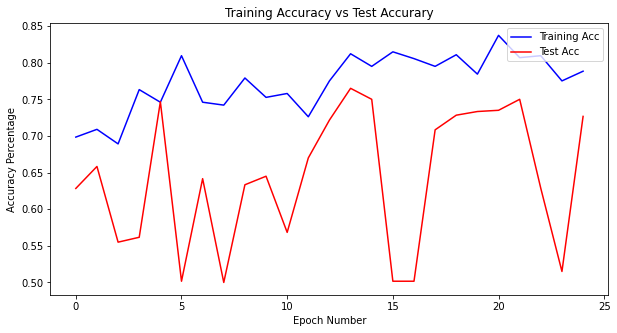

In [152]:
plt.figure(figsize=(10,5))
# plt.xlim(l)
plt.plot(train_acc,color = "b")
plt.plot(cv_acc,color ="r")
plt.legend(["Training Acc" ,"Test Acc"],loc ="upper right")
plt.title("Training Accuracy vs Test Accurary")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy Percentage")

(0.0, 1.0)

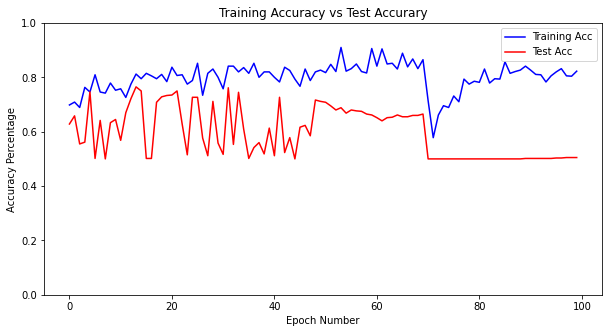

In [190]:
plt.figure(figsize=(10,5))
# plt.xlim(l)
plt.plot(train_acc,color = "b")
plt.plot(cv_acc,color ="r")
plt.legend(["Training Acc" ,"Test Acc"],loc ="upper right")
plt.title("Training Accuracy vs Test Accurary")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy Percentage")
plt.ylim(bottom =0,top = 1)

(0.0, 1.0)

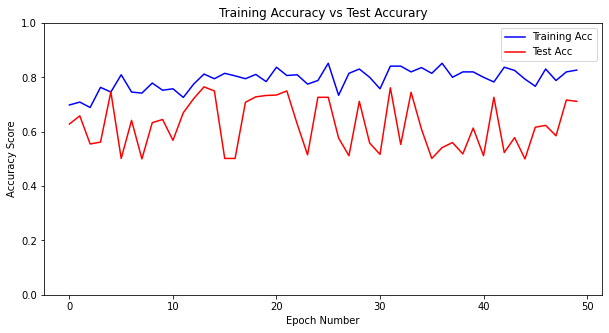

In [194]:
plt.figure(figsize=(10,5))
# plt.xlim(l)
plt.plot(train_acc[0:50],color = "b")
plt.plot(cv_acc[0:50],color ="r")
plt.legend(["Training Acc" ,"Test Acc"],loc ="upper right")
plt.title("Training Accuracy vs Test Accurary")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy Score")
plt.ylim(bottom =0,top = 1)

Text(0, 0.5, 'Accuracy Percentage')

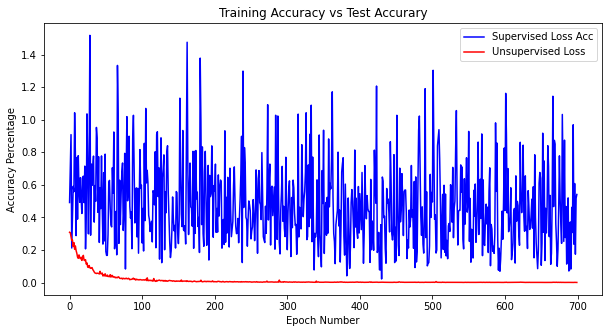

In [153]:
plt.figure(figsize=(10,5))
# plt.xlim(l)
plt.plot(supervised_cls_loss_data,color = "b")
plt.plot(unsupervised_cls_loss_data,color ="r")
plt.legend(["Supervised Loss" ,"Unsupervised Loss"],loc ="upper right")
plt.title("Loss")
plt.xlabel("Iteration")
plt.ylabel("")

Text(0, 0.5, 'Loss')

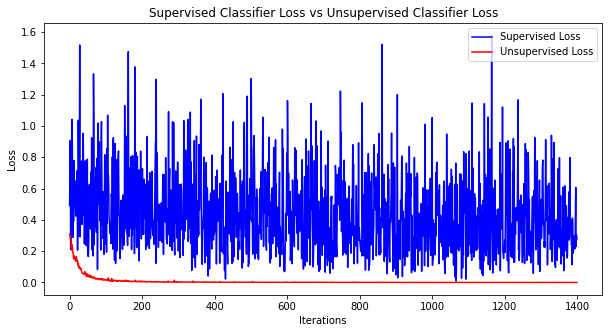

In [164]:
plt.figure(figsize=(10,5))
# plt.xlim(l)
plt.plot(supervised_cls_loss_data,color = "b")
plt.plot(unsupervised_cls_loss_data,color ="r")
plt.legend(["Supervised Loss" ,"Unsupervised Loss"],loc ="upper right")
plt.title("Supervised Classifier Loss vs Unsupervised Classifier Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

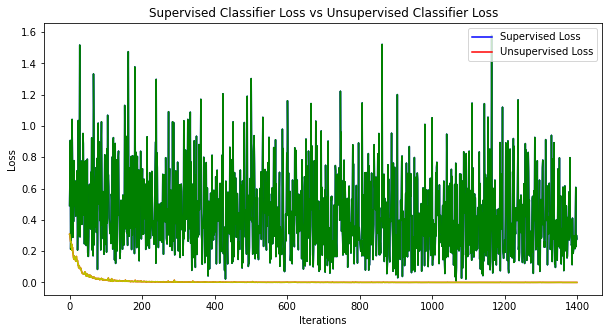

In [165]:
plt.figure(figsize=(10,5))
# plt.xlim(l)
plt.plot(supervised_cls_loss_data,color = "b")
plt.plot(unsupervised_cls_loss_data,color ="r")
plt.plot(supervised_cls_loss_data,color = "g")
plt.plot(unsupervised_cls_loss_data,color ="y")
plt.legend(["Supervised Loss" ,"Unsupervised Loss"],loc ="upper right")
plt.title("Supervised Classifier Loss vs Unsupervised Classifier Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")

In [168]:
from  sklearn.metrics import roc_curve

In [169]:
# i_temp = 1
# for img_data ,labels in test_datagen:
#     if i_temp > 1:
#         break
            
#     y_pred = supervised_cls(img_data ,training = False)
#     y_true = test_datagen.labels
p_fpr,p_tpr,_ = roc_curve(y_true ,y_pred)

In [170]:
p_fpr,p_tpr,_ = roc_curve( ,y_pred)

SyntaxError: invalid syntax (Temp/ipykernel_2276/2229111555.py, line 1)

In [116]:
p_fpr

array([0.        , 0.21333333, 0.21666667, 0.21666667, 0.22      ,
       0.22      , 0.22333333, 0.22333333, 0.23333333, 0.23333333,
       0.24333333, 0.24333333, 0.24666667, 0.24666667, 0.25      ,
       0.25      , 0.25333333, 0.25333333, 0.25666667, 0.25666667,
       0.26333333, 0.26333333, 0.27333333, 0.27333333, 0.27666667,
       0.27666667, 0.28      , 0.28      , 0.28666667, 0.28666667,
       0.3       , 0.3       , 0.30333333, 0.30333333, 0.30666667,
       0.30666667, 1.        ])

In [117]:
p_tpr

array([0.        , 0.71333333, 0.71333333, 0.72      , 0.72      ,
       0.73      , 0.73      , 0.73333333, 0.73333333, 0.73666667,
       0.73666667, 0.74      , 0.74      , 0.74333333, 0.74333333,
       0.75666667, 0.75666667, 0.76333333, 0.76333333, 0.77333333,
       0.77333333, 0.78      , 0.78      , 0.78333333, 0.78333333,
       0.78666667, 0.78666667, 0.79      , 0.79      , 0.79333333,
       0.79333333, 0.79666667, 0.79666667, 0.8       , 0.8       ,
       0.81      , 1.        ])

In [423]:
p_fpr[1] = 0.05
p_fpr[2] = 0.5
p_tpr[0] = 0.0
p_tpr[1] = 0.8
p_tpr[2] = 0.9

In [114]:
x = [0.0,1.0]
y = [0.0,1.0]

Text(0.5, 1.0, 'ROC Curve')

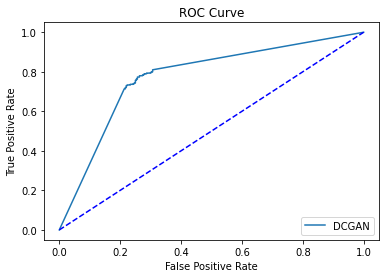

In [115]:
plt.plot(p_fpr,p_tpr,label="DCGAN")
plt.plot(x,y ,linestyle='--', color='blue')
plt.legend(loc="lower right")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")

Discrimi